# IA & Data Science - Final Project 


### Alexis BALAYRE | Augustin CREUSILLET | Julien GODFROY

In [99]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from skimage.measure import label, regionprops
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from collections import Counter
import pickle
import warnings

warnings.filterwarnings("ignore")

In [100]:
df = pd.read_csv('training_labels_200.csv')
image_ids = df['Image_id'].values

# 1. Clustering & visualization

#### I - Data preparation

Import libraries and csv file

In [101]:
# Get csv to pandas.DataFrame
df_viz = pd.read_csv("training_labels_200.csv")

Few tranformations on the dataset : 
- remove NaN values ;
- encode categorical variables ;

In [102]:
# Drop rows with missing values
df_viz = df_viz.dropna()
# Transformer color values to intergers
color_label_encoder = LabelEncoder()
df_viz['Color'] = color_label_encoder.fit_transform(df_viz['Color'])

df_viz.head()

,Image_id,Label,Spot_number,Color,area
0,im-001,0,6,1,0.118669
1,im-002,0,7,1,0.104611
2,im-003,1,17,2,0.158809
3,im-004,1,19,1,0.151580
4,im-005,1,17,2,0.138111


Black => 0 ;
Orange => 1 ;
Red => 2

#### II - Features vizualisation

Let's start with a classic analysis on the distribution of each features.

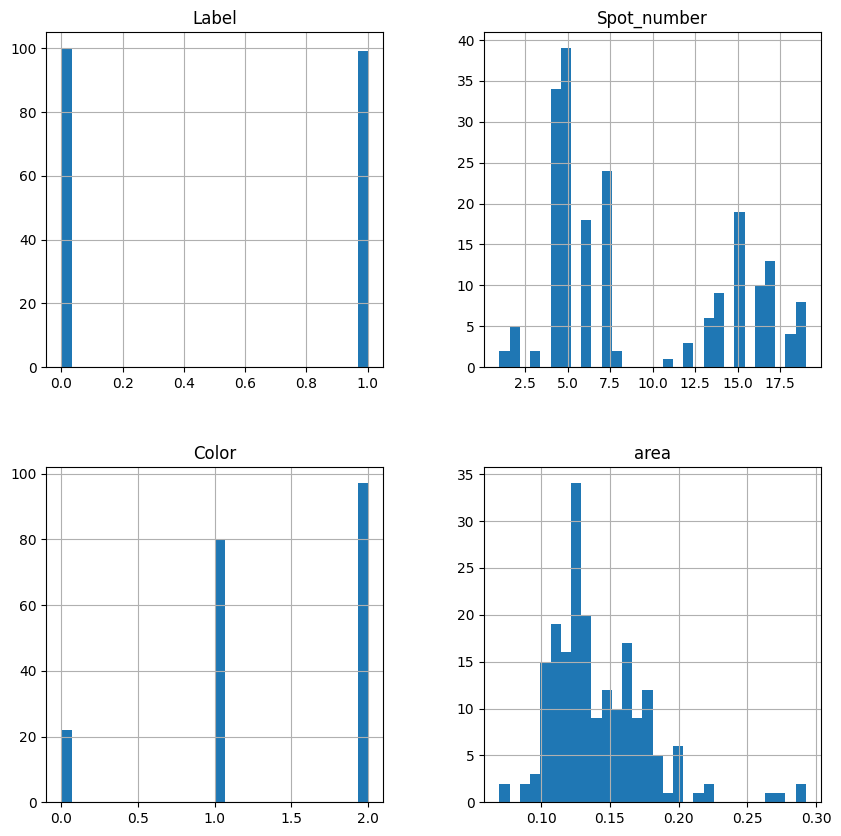

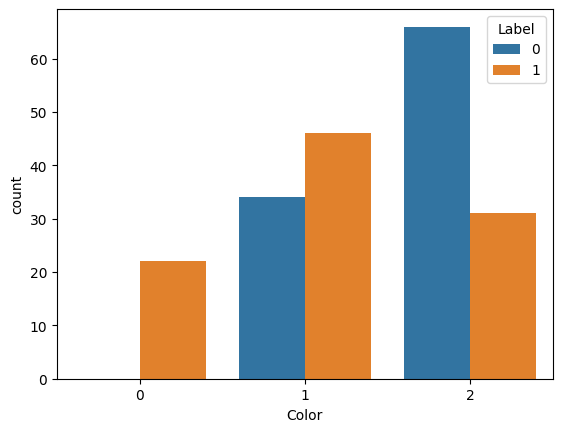

In [103]:
df_viz.hist(bins=30, figsize=(10,10))
plt.show()

# For categorical features like 'Color', we can use countplots
sns.countplot(x='Color', hue='Label', data=df_viz)
plt.show()

Analysis: These graphs allow us to see the distribution of the data. We can see a segmentation of the spot number in two groups:
- a group between 1 and 8 points;
- another group between 11 and 18 points.

Plus, we can see that all black ladybugs are label 1

Now we can try to find correlations between features with an heatmap plot.

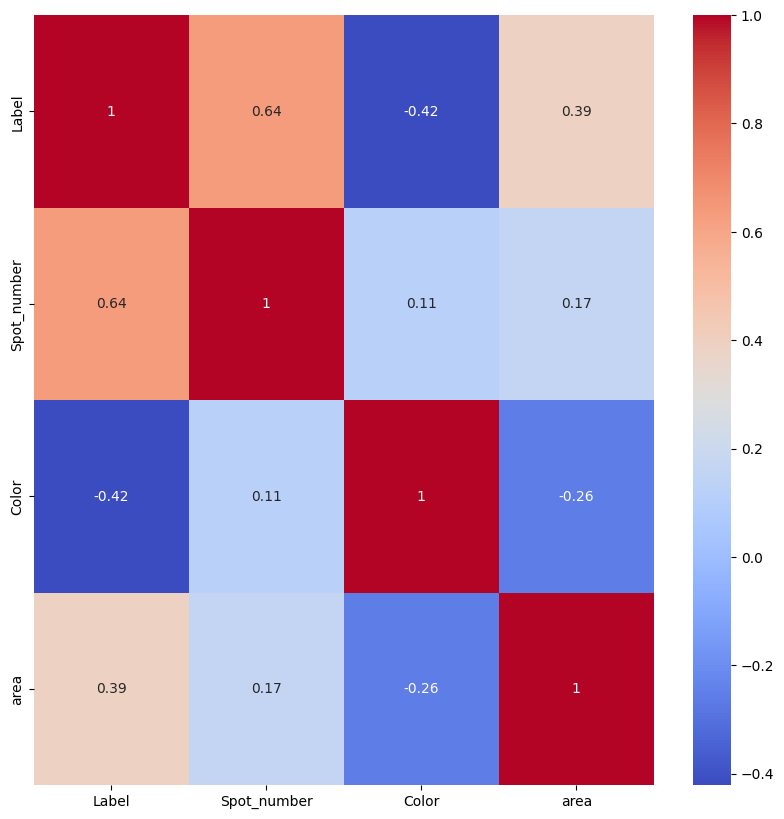

In [104]:
# Correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df_viz.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()


From this heatmap, we can see that the spot-number is correlated to the race of the ladybug (Label) with a coefficient of 0.64%.
We do not particularly distinguish any other correlation between the features.

With some scatter plots, we can try to find some clusters

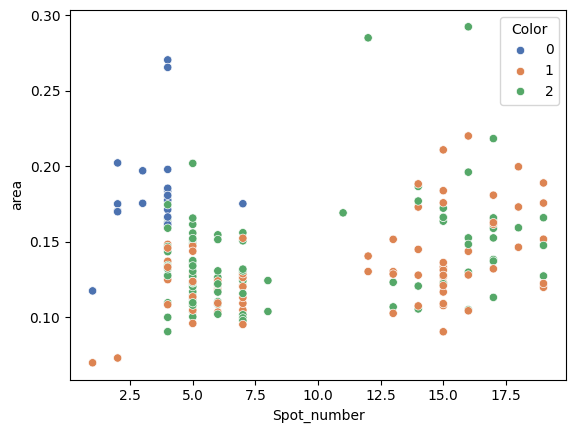

In [105]:
sns.scatterplot(data=df_viz, x="Spot_number", y="area", hue="Color", palette="deep")
plt.show()

From this graph, the online thing we can say is that black laby bugs are more likely to have a low spot number (<7 spots).

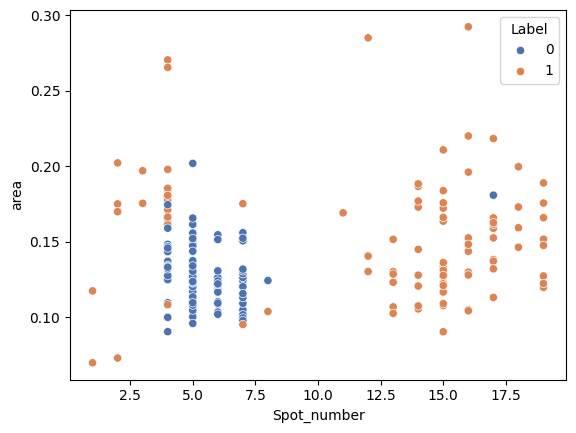

In [106]:

sns.scatterplot(data=df_viz, x="Spot_number", y="area", hue='Label', palette="deep")
plt.show()

Comparing this graph to the previous one, we can conclude that black ladybugs are always label 1.

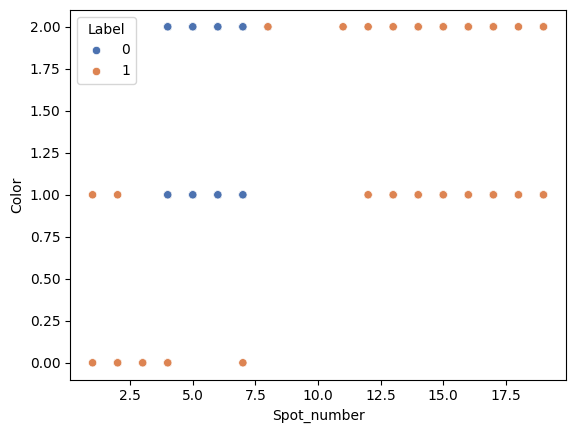

In [107]:
sns.scatterplot(data=df_viz, x="Spot_number", y="Color", hue='Label', palette="deep")
plt.show()

Finally, this graph confirms that black ladybugs are always label 1. Plus, we can see that when the spot number is higher than 8, this also label 0 ladybugs.

#### III - Clustering

Creation of 3 clusters with KMeans algorithm

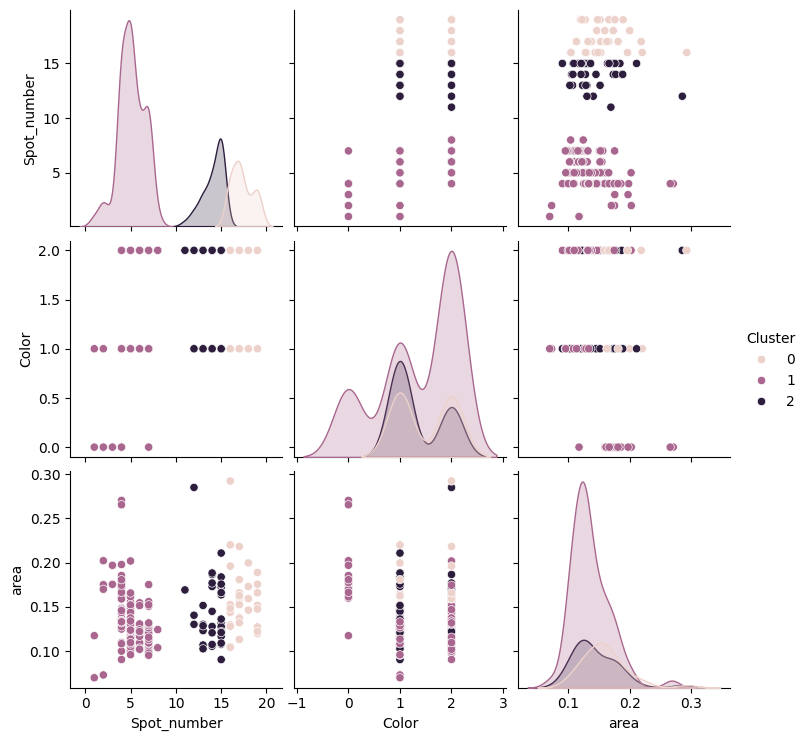

In [108]:
# Transformer color values to intergers
color_label_encoder = LabelEncoder()
df_viz['Color'] = color_label_encoder.fit_transform(df_viz['Color'])

# matrix of features
X = df_viz[['Spot_number', 'Color', 'area']]

# Clustering between 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
df_viz['Cluster'] = kmeans.labels_

# visualize clusters
sns.pairplot(df_viz, hue="Cluster", vars=['Spot_number', 'Color', 'area'])
plt.show()

From these graphs, we can see that we can't distinguish between clusers on the basis of feature area. We deduce that this feature is of little relevance for classification.

On the other hand, color and number of points seem to be important features for classifying ladybirds.

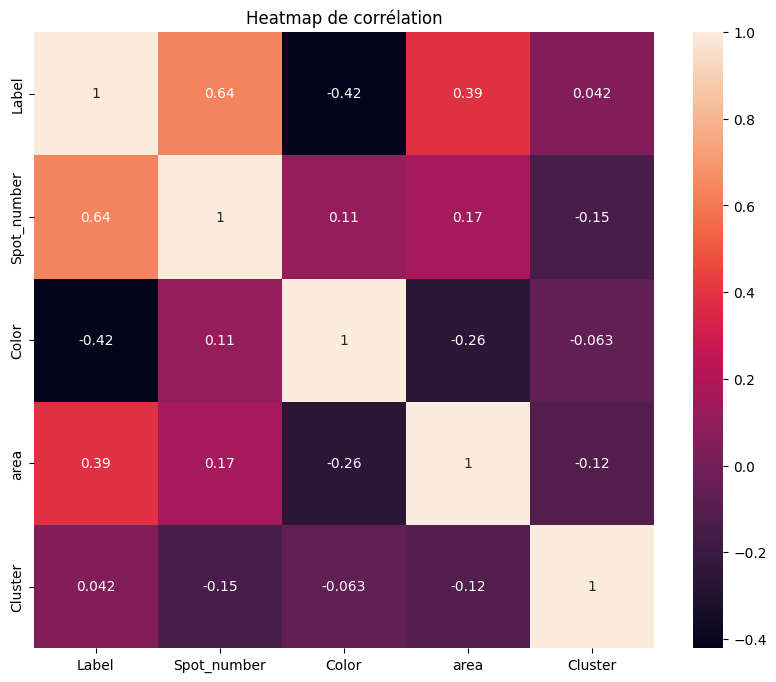

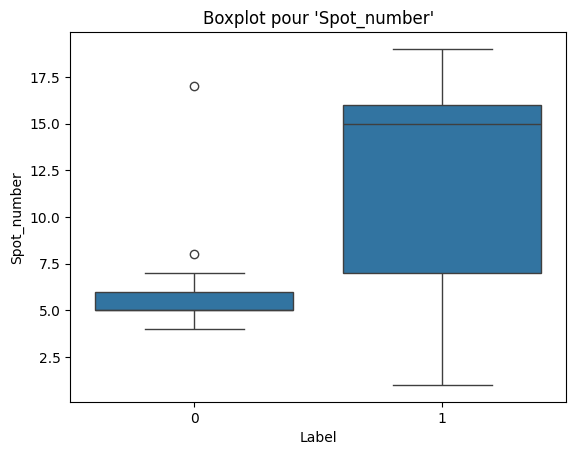

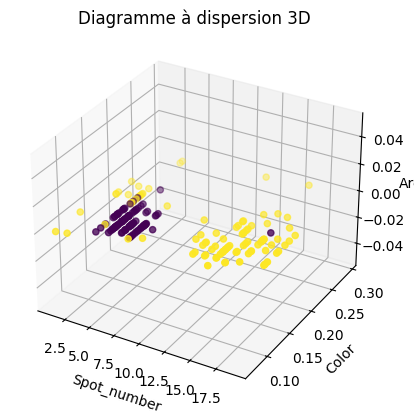

In [109]:
# Heatmap de corrélation
plt.figure(figsize=(10,8))
sns.heatmap(df_viz.corr(numeric_only=True), annot=True)
plt.title("Heatmap de corrélation")
plt.show()


# Boxplots
sns.boxplot(x='Label', y='Spot_number', data=df_viz)
plt.title("Boxplot pour 'Spot_number'")
plt.show()

# Diagrammes à dispersion en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_viz['Spot_number'], df_viz['area'], c=df_viz['Label'])
ax.set_title("Diagramme à dispersion 3D")
ax.set_xlabel('Spot_number')
ax.set_ylabel('Color')
ax.set_zlabel('Area')
plt.show()


These graphs does not allow us to determine any other relevant information on the clusters.
The last 3D vizualisation confirms that the Area feature is not very important for the clustering

# 2. Features Extraction
The aim is to extract features from each image so that they can be classified. We therefore carried out research on the two species of ladybird found in this dataset.

Coccinella septempunctata :
    Orange or red
    Has two white spots on the back of the head
    7 spots on the carapace

Harmonia axyridis :
    Orange, red or black
    Has between 0 and 20 points

To differentiate between them, we decided to use their colour, the number of dots, the size of the dots and the distance between them.
We originally tried to extract the white spots characteristic of Coccinella septempunctata, but we never managed to obtain satisfactory accuracy.

## I. get the color of the elytre

In order to extract the colour of the cocinelle, we use a mask system.The mask is created from the segmented image. We will count the number of pixels in each colour. This will make it very easy to isolate the background and the shell from the image. We will only keep the second most present colour (the first being the background).This mask will then be applied to the RGB image. We will then extract the average of the image's RBG channels.Finally, we will use an algorithm previously trained on our training data to determine the colour (red, orange or black) of the image.

In [110]:
def extract_avg_color(image_seg_path, img_paths):
    img = mpimg.imread(image_seg_path, format='jpg')
    #count the number of each unique pixel value in the image
    counts = Counter(img.flatten())
    counts_list = [key for key, _ in counts.most_common()]
    img[img == counts_list[0]] = 0
    #put everything else to 0 except the elytre
    img[img != counts_list[1]] = 0

    img[img != 0] = 1
    img = img*255
    img = np.expand_dims(img, axis=2)
    img = np.repeat(img, 3, axis=2)
    #apply the mask to the original image
    img = img * mpimg.imread(img_paths)
    img = np.array(img)  # Convertir en array numpy pour le calcul
    avg_color_per_row = np.average(img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)[:3]  # Ignorer le canal alpha
    avg_color_str = ', '.join([str(c) for c in avg_color])
    return avg_color_str

In [111]:
img_paths = '/Users/alexis/Programmation/ai-project/data/training/im_seg/'

list_spot = []
list_mean_radius = []

for i,image_id in enumerate(image_ids):
    image_seg_path = img_paths + image_id +'_seg' + '.png'
    image_path = img_paths + image_id +'_im'+'.png'
    avg_color = extract_avg_color(image_seg_path, image_path)
    df.loc[i, 'avg_color'] = avg_color

In [112]:
le = LabelEncoder()
df['Color_Encoded'] = le.fit_transform(df['Color'])

average_colors = np.array([np.fromstring(i, sep=',') for i in df['avg_color'].values])


color_labels = df['Color'].values

In [113]:
#train on the entiere dataset
X_train = average_colors
y_train = color_labels 

# Créer et entraîner le classificateur
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

## II. get the number of spot and the mean area of the spots 

To do this, we're going to use the segmented image.As with colour, we will count the number of pixels per colour.

- the most common colour: the background
- 2nd most present colour: the shell

Next, we faced a challenge. The head and eyes were very complicated to remove from the image.So we used the skimming label function, which groups neighbouring pixels together. The head and eyes will then appear as a single block. Using the same technique as for the background and shell, it's easy to isolate and remove them. All that's left are the dots.

We also had problems with the average air. The images are not the same size and the ladybirds are not all taken at the same distance from the lens. We therefore decided to recover the air from the ladybird without the bottom. So, whatever the size of the image or the place occupied by the ladybird in the image, we will have usable air for each image.

In [114]:
def spot_count(img_paths, filename):
    img = mpimg.imread(img_paths, format='jpg')
    #count the number of each unique pixel value in the image
    counts = Counter(img.flatten())
    counts_list = [key for key, _ in counts.most_common()]
    img[img == counts_list[0]] = 0
    #on récupère l'air de la carapace ce qui assur qu'il n'y ai pas de problème de taille d'image ou de distance entre l'objectif et la 
    #cocinelle
    area = np.sum(img > 0)
    img[img == counts_list[1]] = 0
    label_image = label(img>0)
    counts = np.bincount(label_image.flat)
    # Ignorer le label 0 car il représente l'arrière-plan
    counts[0] = 0
    # Obtenir le label qui a le plus de pixels (la tête de la cocinelle)
    most_common_label = np.argmax(counts)
    # Mettre tous les pixels avec le label le plus commun à 0
    label_image[label_image == most_common_label] = 0
    props = regionprops(label_image)
    # Obtenir le rayon équivalent moyen des régions restantes
    mean_radius = np.mean([prop.equivalent_diameter for prop in props]) / np.sqrt(area)
    
    label_image = label(label_image>0)
    #obtenir la distance moyenne entre les taches et le rendre proportionnel à la taille de l'image
    

    return label_image.max(), mean_radius

In [115]:
# OPTIONAL

# Charger le modèle
with open('finalized_color_model.sav', 'rb') as f:
    clf = pickle.load(f)

# Charger le LabelEncoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# 3. Train et Test

## I. Création d'un dataset de test pour notre features extraction

For this part, we decided to use our feature extraction function on our given database to see how our algorithms performed and to train a machine learning model to classify our ladybirds.

In [116]:
img_paths = '/Users/alexis/Programmation/ai-project/data/training/im_seg/'
df_pred = pd.DataFrame(columns=['Color', 'Spot_number', 'area'])

list_spot = []
list_mean_radius = []

for i,image_id in enumerate(image_ids):
    image_seg_path = img_paths + image_id +'_seg' + '.png'
    image_path = img_paths + image_id +'_im'+'.png'
    avg_color = extract_avg_color(image_seg_path, image_path)
    # Convertir la couleur moyenne en tableau NumPy et ajouter une autre dimension
    avg_color_array = np.fromstring(avg_color, sep=',')
    avg_color_array = np.expand_dims(avg_color_array, axis=0)
    # Prédire la couleur
    y = clf.predict(avg_color_array)
    df_pred.loc[i, 'Color'] = y[0]

    #predict the number of spot
    spot, mean_radius = spot_count(image_seg_path, image_id)
    #put the result in the df
    df_pred.loc[i, 'Spot_number'] = spot +1
    df_pred.loc[i, 'area'] = mean_radius

In [117]:
df_pred

,Color,Spot_number,area
0,O,6,0.118669
1,O,7,0.104611
2,R,16,0.158809
3,O,14,0.15158
4,R,18,0.138111
...,...,...,...
195,R,7,0.131732
196,B,5,0.196971
197,R,4,0.174454
198,B,8,0.180658


## II. resutat de nos extraction de features

In [118]:
# socre de prediction de la couleur
score = np.mean(df_pred['Color'].values == df['Color'].values)
print('Colour prediction score:', score)


# rsme de la prédiction du nombre de tache
rmse = np.sqrt(np.mean((df_pred['Spot_number'].values - df['Spot_number'].values)**2))
print('RMSE of the prediction of the number of spots:', rmse)

Colour prediction score: 0.96
RMSE of the prediction of the number of spots: 2.8284271247461903


In terms of colour prediction, the colour extraction dataset seems to work almost perfectly with an accuracy of 95%. Insofar as the basic dataset was filled in by hand and therefore inevitably contains false results due to the red/orange hue, this result is more than acceptable.

However, the prediction of points is much less accurate, mainly due to the fact that the segmentation of some images is not optimal, with some very close points being counted as a single point instead of 2. On 'conventional' images, the algorithm works very well.

In [119]:
# One-hot encode the color feature
df_pred = pd.get_dummies(df_pred, columns=['Color'])
df = pd.get_dummies(df, columns=['Color'])

In [120]:
df_pred = df_pred.fillna(0)
df = df.fillna(0)

## III. Train test split
Preparing the training data set to select the machine learning algorithm
The 'stratify=y' option ensures that the distribution of labels 0 and 1 is the same in the training set as in the test set.

In [121]:
# Prepare the features and labels
X = df.drop(['Image_id', 'Label', 'avg_color', 'Color_Encoded'], axis=1)
y = df['Label']


# Split the data into training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## IV. Choice of machine learning algorithm

We tried several classification algorithms such as :
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- KNN

After several tests, we decided to continue with the RandomForestClassifier as it gave us excellent results with very few parameters and very quickly.

In [122]:
#training random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [123]:
#predict the test set
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print(score)

0.975


We can see that we obtain 97.5% accuracy on the test set without changing any parameters, which is excellent.

## V. Optimisation

In [124]:
# Définir les paramètres à tester
param_distributions = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2']
}

# Créer le modèle
rf = RandomForestClassifier(random_state=42)

# Créer la recherche aléatoire
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=100, cv=5, n_jobs=-1, verbose=0, random_state=42)

# Ajuster la recherche aléatoire aux données
random_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print(random_search.best_params_)

# Utiliser le meilleur modèle pour faire des prédictions
best_rf = random_search.best_estimator_

{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}


In [125]:
#print the 5 best set of parameters with the associated score
results = pd.DataFrame(random_search.cv_results_)
results.sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
99,1.178303,0.305257,0.021020,0.003241,1000,15,1,log2,10,"{'n_estimators': 1000, 'min_samples_split': 15...",1.0,1.0,0.90625,0.96875,0.9375,0.9625,0.036443,1
98,1.472119,0.020817,0.035441,0.011263,1000,15,2,log2,40,"{'n_estimators': 1000, 'min_samples_split': 15...",1.0,1.0,0.90625,0.96875,0.9375,0.9625,0.036443,1
24,1.834128,0.094134,0.043393,0.012315,1000,15,2,log2,50,"{'n_estimators': 1000, 'min_samples_split': 15...",1.0,1.0,0.90625,0.96875,0.9375,0.9625,0.036443,1
72,0.348856,0.039173,0.018434,0.013458,200,15,2,sqrt,30,"{'n_estimators': 200, 'min_samples_split': 15,...",1.0,1.0,0.90625,0.96875,0.9375,0.9625,0.036443,1
69,1.584689,0.060640,0.051542,0.016630,1000,5,4,log2,None,"{'n_estimators': 1000, 'min_samples_split': 5,...",1.0,1.0,0.90625,0.96875,0.9375,0.9625,0.036443,1


Optimisation does not allow us to isolate an optimal set of parameters compared with the basic parameters (see the mean_test_score above, which are each 0.9625). We therefore decided to stick with these parameters.

## VI. Cross validation

In [126]:
#cross validation
scores = cross_val_score(rf, X_test, y_test, cv=10)
print(scores)

[1.   0.75 1.   1.   1.   1.   1.   1.   1.   1.  ]


The results are excellent when we run a cross-validation on the test dataset. All that remains is to train the model on the entire dataset to be able to predict the final dataset as accurately as possible.

In [127]:
# train the model with the entire dataset
rf.fit(X, y)

RandomForestClassifier(random_state=42)

## VII. Clustering

In [128]:
#PCA
pca = PCA(n_components=2)
PCA_data = df.drop(['Image_id', 'Label', 'avg_color', 'Color_Encoded'], axis=1)
PCA_target = df['Label']

PCA_val = pca.fit_transform(PCA_data)
df_PCA = pd.DataFrame(data = PCA_val, columns = ['PC1', 'PC2']) 
df_PCA_class = pd.concat([df_PCA, pd.DataFrame(PCA_target, columns=['Classe'])], axis = 1)

In [129]:
def plot_PCA(X, Y, target_name, title):
    plt.figure(figsize=(16, 9))
    for i, target_name in zip(np.unique(Y), target_name):
        plt.scatter(
            X[Y == i, 0], X[Y == i, 1], alpha=0.8, label=target_name
        )
        
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title(title, size=18)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    #print the explained variance ratio on the two axis
    print(pca.explained_variance_ratio_)

[0.98088882 0.0147287 ]


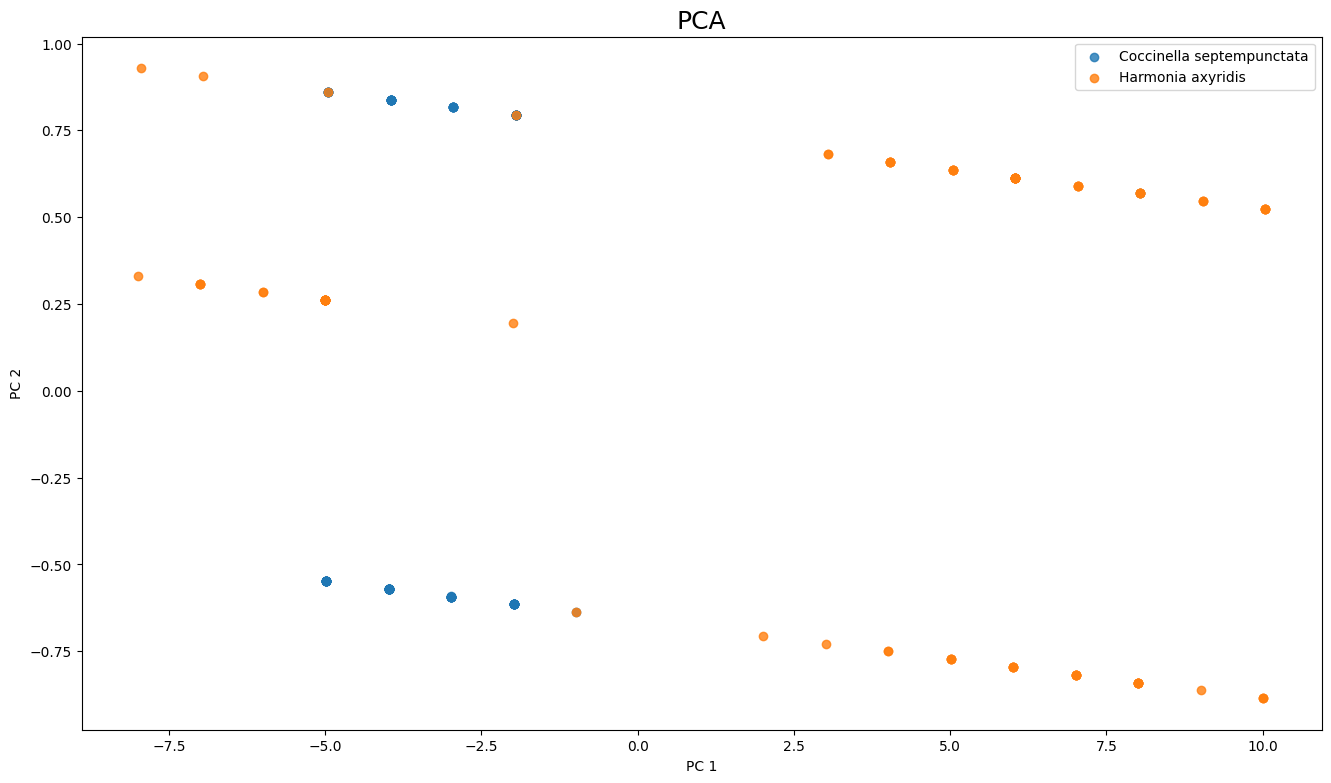

In [130]:
target_names = ['Coccinella septempunctata', 'Harmonia axyridis']

plot_PCA(PCA_val, PCA_target, target_names, "PCA")

The PCA shows around 3 clusters. However, the separation between the two species is very small, which may pose a problem for clustering.

[0.98088882 0.0147287 ]


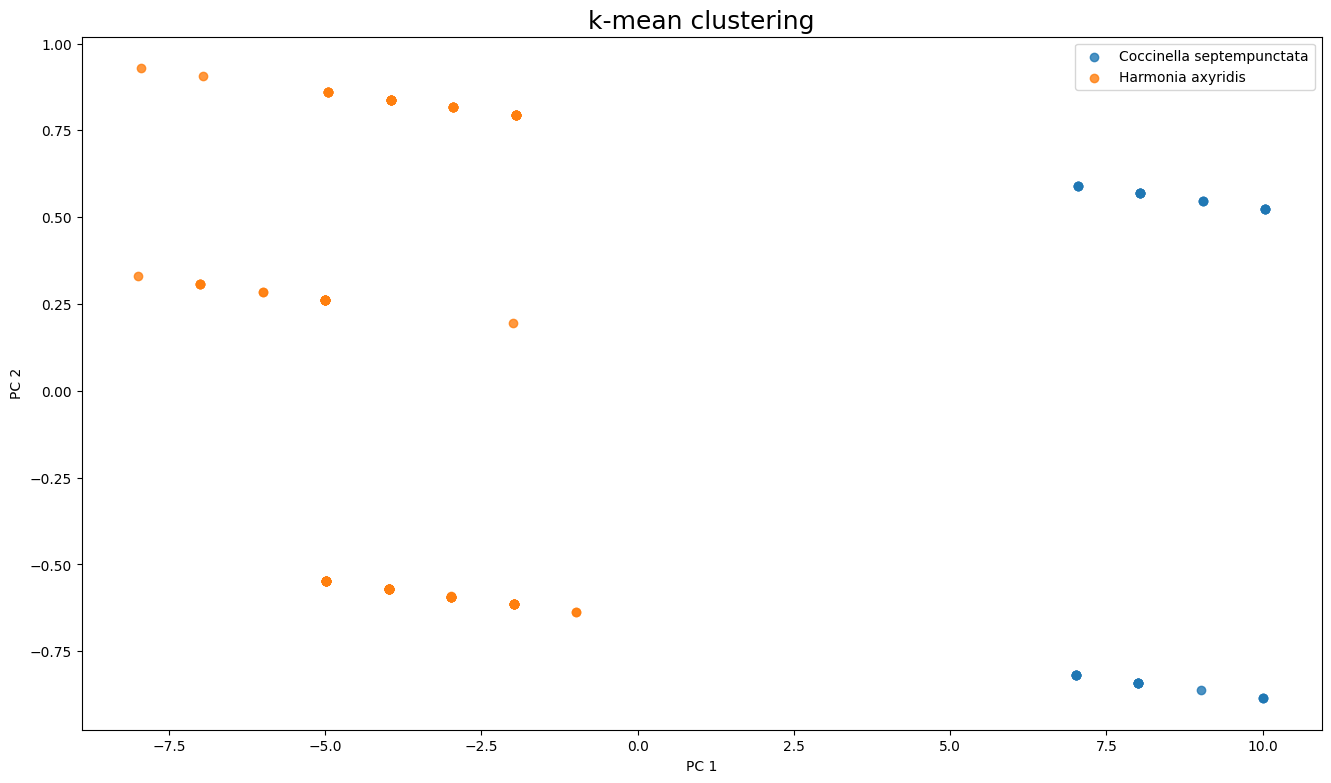

In [131]:
kmeans = KMeans(n_clusters=3, n_init=5, max_iter=300, random_state=10).fit(PCA_data)
kmeans.score(PCA_data)
prediction = kmeans.predict(PCA_data)
plot_PCA(PCA_val, prediction, target_names, "k-mean clustering")

From the distribution of the data, we can see that the two classes are well separated.
We can therefore expect our model to perform well, especially as the variance explained by the two axes is very good. 
axes is 0.99, which is very good.

In addition, we can see that the 7-point cocinelles are separated into two groups, which is consistent with 
the two sub-classes of 7-spotted ladybirds (see Wikipedia : 
- Coccinella septempunctata brucki Mulsant, 1866
- Coccinella septempunctata septempunctata Linnaeus, 1758). 

Finally, we can see that Asian ladybirds are separated into 3 groups, which is also consistent because there are many subspecies of this species (the black one to name but one).

# 4. Test

In [132]:
# get the firt 50 image id of the df to a list
test_image_ids = df['Image_id'].tolist()
test_image_ids = image_ids[:50]

In [133]:
df_test = pd.DataFrame(columns=['Image_id', 'Color', 'Spot_number', 'area'])

In [134]:
img_paths = '/Users/alexis/Programmation/ai-project/data/test/'
for i,image_id in enumerate(test_image_ids):
    image_seg_path = img_paths + image_id +'_seg' + '.png'
    image_path = img_paths + image_id +'_im'+'.png'
    avg_color = extract_avg_color(image_seg_path, image_path)
    # Convertir la couleur moyenne en tableau NumPy et ajouter une autre dimension
    avg_color_array = np.fromstring(avg_color, sep=',')
    avg_color_array = np.expand_dims(avg_color_array, axis=0)
    # Prédire la couleur
    y = clf.predict(avg_color_array)
    df_test.loc[i, 'Color'] = y[0]

    #predict the number of spot
    spot, mean_radius = spot_count(image_seg_path, spot_count)
    
    #put the result in the df
    df_pred.loc[i, 'Spot_number'] = spot +1
    df_pred.loc[i, 'area'] = mean_radius 

df_test['Image_id'] = test_image_ids

In [135]:
#predict the label
df_test = pd.get_dummies(df_test, columns=['Color'])
X_test = df_test.drop(['Image_id'], axis=1)
#replace nan with 0
X_test = X_test.fillna(0)

In [136]:
y_pred = rf.predict(X_test)

In [137]:
test_labels = pd.DataFrame(columns=['Image_id', 'Label','Spot_number'])
test_labels['Image_id'] = df_test['Image_id']
test_labels['Label'] = y_pred
test_labels['Spot_number'] = df_test['Spot_number']
test_labels.to_csv('test_labels.csv', index=False)

# 5. Deep Learning Appendix

For interest, we decided to explore a deep learning solution. Although we couldn't use it because we had to extract our features ourselves, we did try to run a model.

We can quite easily achieve 97% accuracy with this type of algorithm, with very little optimisation. Initially we had problems with overfitting, but we managed to resolve these by increasing the size of the training dataset. To do this we searched the internet for other images of ladybirds and mirrored the images we already had.

In [156]:
# Chargement des images et des labels
data_dir = '/Users/alexis/Programmation/ai-project/data/training/im_seg/'
df_labels = pd.read_csv('training_labels_200.csv')
df = df_labels.drop(['Image_id','Spot_number'], axis=1)
image_size = (64, 64)

def load_image(path_to_images, filename):
    img = Image.open(os.path.join(path_to_images, filename))
    img = img.resize(image_size)
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

In [157]:
X = []
y = []
path_to_images = '/Users/alexis/Programmation/ai-project/data/training/im/'
for i,filename in enumerate(os.listdir(path_to_images)):
    X.append(load_image(path_to_images,filename))
    y.append(df['Label'].iloc[i])

X = np.array(X)
y = np.array(y)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12,stratify=df['Label'])

In [159]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [160]:
# Compilation du modèle
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [161]:
# Entraînement du modèle
model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test))
model.save_weights('weights.h5')

Epoch 1/15


6/6 [==============================] - 1s 62ms/step - loss: 0.7071 - accuracy: 0.4489 - val_loss: 0.6929 - val_accuracy: 0.5833
Epoch 2/15
6/6 [==============================] - 0s 42ms/step - loss: 0.6922 - accuracy: 0.5284 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/15
6/6 [==============================] - 0s 54ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 4/15
6/6 [==============================] - 0s 44ms/step - loss: 0.6905 - accuracy: 0.5170 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/15
6/6 [==============================] - 0s 42ms/step - loss: 0.6882 - accuracy: 0.6023 - val_loss: 0.6952 - val_accuracy: 0.4167
Epoch 6/15
6/6 [==============================] - 0s 43ms/step - loss: 0.6852 - accuracy: 0.5966 - val_loss: 0.7003 - val_accuracy: 0.4167
Epoch 7/15
6/6 [==============================] - 0s 48ms/step - loss: 0.6679 - accuracy: 0.6534 - val_loss: 0.7516 - val_accuracy: 0.4583
Epoch 8/15
6/6 [======================